# Initial Setup

Import Libraries






In [124]:
import math
import random
from collections import namedtuple, deque

import gym
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd

Setup CUDA Variable

In [125]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

# Define the environment, network and replay buffer classes

Define the MDP environment as given in the paper

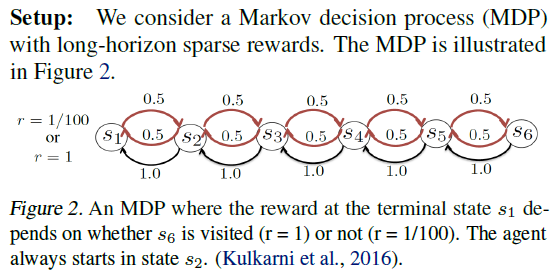

In [126]:
class StochasticMDP:
    def __init__(self, num_states):
        self.end           = False
        self.current_state = 2
        self.num_actions   = 2
        self.num_states    = num_states
        self.p_right       = 0.5

    def reset(self):
        self.end = False
        self.current_state = 2
        state = np.zeros(self.num_states)
        state[self.current_state - 1] = 1.
        return state

    def step(self, action):
        
        if self.current_state != 1:
            
            #Random action
            if action == 1:
                if random.random() < self.p_right and self.current_state < self.num_states:
                    self.current_state += 1
                else:
                    self.current_state -= 1
            
            #Action: Move Left
            if action == 0:
                self.current_state -= 1
                
            if self.current_state == self.num_states:
                self.end = True
        
        state = np.zeros(self.num_states)
        state[self.current_state - 1] = 1.
        
        #Reached Final State
        if self.current_state == 1:
            #Been to State s6
            if self.end:
                return state, 1.00, True, {}
            #Not been to State s6
            else:
                return state, 1.00/100.00, True, {}
        #Not in Final State
        else:
            return state, 0.0, False, {}

Create the Replay Buffer to be used by both the models

In [127]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer   = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done

    def clear(self):
        self.buffer.clear()
    
    def __len__(self):
        return len(self.buffer)

Define the network

In [128]:
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, layer_size):
        super(Net, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(num_inputs, layer_size),
            nn.ReLU(),
            nn.Linear(layer_size, num_outputs)
        )
    
    def forward(self, x):
        return self.layers(x)
    
    def get_action(self, state, epsilon):
        #Epsilon-Greedy Techinique
        
        #For Pr(1-Epsilon) : choosing max Q-value Action
        if random.random() > epsilon:
            state  = torch.FloatTensor(state).unsqueeze(0)
            action = self.forward(Variable(state, volatile=True)).max(1)[1]
            return action.data[0]
        #For Pr(Epsilon) : choosing a random Action
        else:
            return random.randrange(num_actions)

Create the one-hot encoding used for goal states

In [129]:
#Binary like representation of states, used for ease of calculations
def to_onehot(x, num_states):
    oh = np.zeros(num_states)
    oh[x - 1] = 1.
    return oh

# Define the train & update method for the supplied model

In [130]:
def update(model, optimizer, replay_buffer, batch_size):
    if batch_size > len(replay_buffer):
        return
        
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    
    state      = Variable(torch.FloatTensor(state))
    next_state = Variable(torch.FloatTensor(next_state), volatile=True)
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    q_value = model(state)
    q_value = q_value.gather(1, action.unsqueeze(1)).squeeze(1)
    
    next_q_value     = model(next_state).max(1)[0]
    #0.99 value of gamma? 
    expected_q_value = reward + 0.99 * next_q_value * (1 - done)
   
    #Mean Squared Error
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

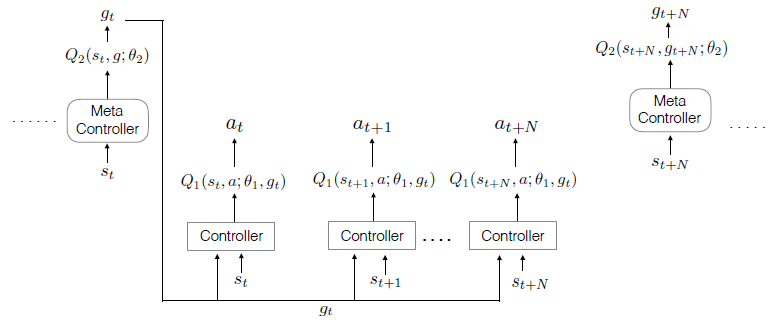

In [131]:
def train(model, meta_model, env, replay_buffer, meta_replay_buffer, optimizer, meta_optimizer, Sub_Trans_Bool, Sub_Tran_Step_size = 0):
    
    #Like Atari Games, Frame here refers to one step for the controller
    frame_idx  = 1
    
    #Initializing all variables
    state = env.reset()
    done = False
    all_rewards = []
    episode_reward = 0

    #It is playing the game for Fixed Number of Frames
    while frame_idx < NUM_FRAMES:
        
        #Meta Controller gives the goal state to Controller
        goal = meta_model.get_action(state, epsilon_by_frame(frame_idx))
        onehot_goal  = to_onehot(goal, env.num_states)
        meta_state = state
        extrinsic_reward = 0
        
        #Initialized Subtransition Replay Buffer
        subtransition_replay_buffer = []
        
        while not done and goal != np.argmax(state):
            goal_state  = np.concatenate([state, onehot_goal])
            
            #Action to be performed by the Controller in this frame
            action = model.get_action(goal_state, epsilon_by_frame(frame_idx))
            next_state, reward, done, _ = env.step(action)

            episode_reward   += reward
            
            #Extrinsic Reward
            extrinsic_reward += reward
            
            #Intrinsic Reward
            intrinsic_reward = 1.0 if goal == np.argmax(next_state) else 0.0
            
            #Intrinsic Reward used for Controller
            replay_buffer.push(goal_state, action, intrinsic_reward, np.concatenate([next_state, onehot_goal]), done)
            state = next_state
            
            update(model, optimizer, replay_buffer, BATCH_SIZE)
            update(meta_model, meta_optimizer, meta_replay_buffer, BATCH_SIZE)
            
            frame_idx += 1

            #Adding to Subtransition Buffer
            if Sub_Trans_Bool and (frame_idx % Sub_Tran_Step_size == 0) :
                    subtransition_replay_buffer.append([state,extrinsic_reward,done])
        
        #Adding to Meta Buffer from Subtransition Buffer after Controller completes
        if Sub_Trans_Bool:
            for t in range(len(subtransition_replay_buffer)):
                meta_replay_buffer.push(subtransition_replay_buffer[t][0], goal, extrinsic_reward-subtransition_replay_buffer[t][1], state, subtransition_replay_buffer[t][2])  
            
        #Extrinsic Reward used for Controller
        meta_replay_buffer.push(meta_state, goal, extrinsic_reward, state, done)
        
        
        
        if done:
            
            #Resetting all variables after the game completed
            state = env.reset()
            done  = False
            all_rewards.append(episode_reward)
            episode_reward = 0
    return all_rewards

# Set Hyperparameter values

Environemnt

In [132]:
NUM_STATES = 6

Storage

In [133]:
BUFFER_SIZE = 10000

DQN Model

In [134]:
NN_LAYER_SIZE = 256
NUM_FRAMES = 10000
BATCH_SIZE = 128
COARSENING_STEP_SIZE = 100

Sub-Transition

In [135]:
Sub_Tran_Step_size = 20

# Instantiate the envrionment, models and their replay buffers

In [136]:
env = StochasticMDP(NUM_STATES)

num_goals    = env.num_states
num_actions  = env.num_actions

#Why 2*num_goals ?

model        = Net(2*num_goals, num_actions, NN_LAYER_SIZE)
target_model = Net(2*num_goals, num_actions, NN_LAYER_SIZE)

meta_model        = Net(num_goals, num_goals, NN_LAYER_SIZE)
target_meta_model = Net(num_goals, num_goals, NN_LAYER_SIZE)

model_sub        = Net(2*num_goals, num_actions, NN_LAYER_SIZE)
target_model_sub = Net(2*num_goals, num_actions, NN_LAYER_SIZE)

meta_model_sub        = Net(num_goals, num_goals, NN_LAYER_SIZE)
target_meta_model_sub = Net(num_goals, num_goals, NN_LAYER_SIZE)

if USE_CUDA:
    model             = model.cuda()
    target_model      = target_model.cuda()
    meta_model        = meta_model.cuda()
    target_meta_model = target_meta_model.cuda()

    model_sub             = model_sub.cuda()
    target_model_sub      = target_model_sub.cuda()
    meta_model_sub        = meta_model_sub.cuda()
    target_meta_model_sub = target_meta_model_sub.cuda()

optimizer      = optim.Adam(model.parameters())
meta_optimizer = optim.Adam(meta_model.parameters())

optimizer_sub      = optim.Adam(model_sub.parameters())
meta_optimizer_sub = optim.Adam(meta_model_sub.parameters())

replay_buffer      = ReplayBuffer(BUFFER_SIZE)
meta_replay_buffer = ReplayBuffer(BUFFER_SIZE)

Setup the Epsilon hyper-paramter values as mentioned in the paper

In [137]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

In [138]:
def coarsening(reward_list, step_size):
    avg_reward_list = [np.mean(reward_list[i:i + step_size]) for i in range(0, len(reward_list), step_size)]
    return avg_reward_list

# Train the agents

h-DQN agent

In [139]:
replay_buffer.clear()
meta_replay_buffer.clear()
hdqn_rewards = train(model, meta_model, env, replay_buffer, meta_replay_buffer, optimizer, meta_optimizer, False)
hdqn_avg_rewards = coarsening(hdqn_rewards, COARSENING_STEP_SIZE)

C:\Users\sum\.conda\envs\ML_Demo\lib\site-packages\ipykernel_launcher.py:2: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


h-DQN with sub-transition

In [140]:
replay_buffer.clear()
meta_replay_buffer.clear()
hdqn_subt_rewards = train(model_sub, meta_model_sub, env, replay_buffer, meta_replay_buffer, optimizer_sub, meta_optimizer_sub, True, Sub_Tran_Step_size)
hdqn_subt_avg_rewards = coarsening(hdqn_subt_rewards, COARSENING_STEP_SIZE)

C:\Users\sum\.conda\envs\ML_Demo\lib\site-packages\ipykernel_launcher.py:2: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


# Plot

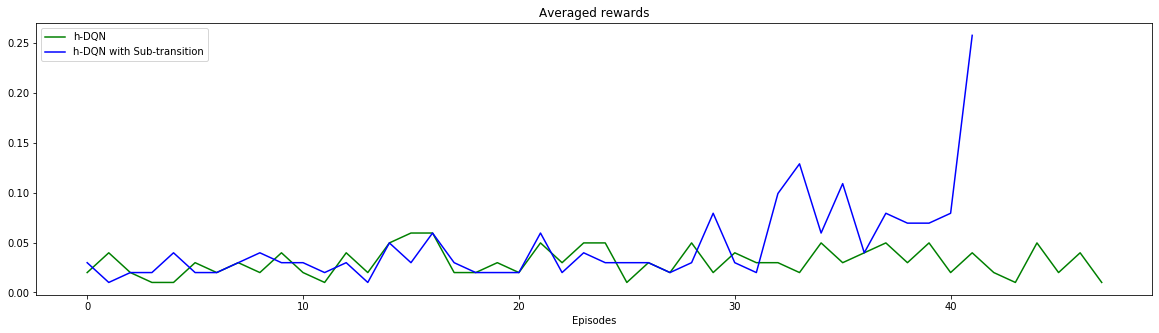

In [141]:
plt.figure(figsize=(20,5))
plt.title("Averaged rewards")
plt.xlabel("Episodes")
plt.plot(hdqn_avg_rewards, color='g', label="h-DQN")
plt.plot(hdqn_subt_avg_rewards, color='b', label="h-DQN with Sub-transition")
plt.legend(loc='upper left')
plt.show()

# Result

Average Reward without Sub-transition

In [142]:
np.mean(hdqn_rewards)

0.031036974075648108

In [143]:
np.var(hdqn_rewards)

0.020384050056632134

Average Reward with Sub-transition

In [144]:
np.mean(hdqn_subt_rewards)

0.04202091439688715

In [145]:
np.var(hdqn_subt_rewards)

0.030675366294105506